<a href="https://colab.research.google.com/github/julesripoll/crypto-trading-bot/blob/jules_branch/bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tf_agents.agents import DqnAgent
import pandas as pd
from tf_agents.environments import tf_py_environment
import tensorflow as tf
from tf_agents.utils import common
from tf_agents.specs import tensor_spec
from tf_agents.networks.q_rnn_network import QRnnNetwork
from tf_agents.drivers import py_driver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers.tf_uniform_replay_buffer import  TFUniformReplayBuffer
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from numpy import random
from tf_agents.metrics import tf_metrics
import numpy as np
import tf_agents.trajectories as trajectory
import datetime as dt
import matplotlib.pyplot as plt
from trade import TradingEnvTrain

In [2]:
eth=pd.read_csv("~/Developer/Trading bots/Trading bot crypto/Data/HitBTC_ETHUSD_1h.csv", sep=",")
eth=eth.drop(['Date', 'Unix Timestamp', 'Symbol','Volume USD'], axis=1)
eth.head()

,Open,High,Low,Close,Volume ETH
0,533.85,535.36,530.52,534.73,193.34
1,532.83,536.20,529.82,533.85,272.11
2,524.71,535.44,523.64,532.83,569.97
3,519.44,525.39,514.64,524.71,490.78
4,528.51,528.51,518.68,519.44,556.35


In [5]:
#init de l'environnement
train_py_env=TradingEnvTrain(eth[:300], window_size=5,tc=10)
print(train_py_env.state)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)


     Open    High     Low   Close  Volume ETH
0  533.85  535.36  530.52  534.73      193.34
1  532.83  536.20  529.82  533.85      272.11
2  524.71  535.44  523.64  532.83      569.97
3  519.44  525.39  514.64  524.71      490.78
4  528.51  528.51  518.68  519.44      556.35


In [6]:
#let s take some random steps in the environment
rewards = []
steps = []
num_episodes = 5

for i in range(num_episodes):
  print('episode',i)
  time_step = train_env.reset()
  episode_reward = 0
  episode_steps = 0
  while not time_step.is_last():
    action=random.randint(0,3)
    time_step = train_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  print('episode steps', episode_steps)
  print('#########################################################################')
  rewards.append(episode_reward)
  steps.append(episode_steps)

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

print('num_episodes:', num_episodes, 'num_steps:', num_steps)
print('avg_length', avg_length, 'avg_reward:', avg_reward)

episode 0
reset has been hit 0
transitioning, 1
transitioning, 1
transitioning, 1
episode terminated 2
episode steps 4
#########################################################################
episode 1
reset has been hit 0
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
episode terminated 2
episode steps 7
#########################################################################
episode 2
reset has been hit 0
episode terminated 2
episode steps 1
#########################################################################
episode 3
reset has been hit 0
transitioning, 1
episode terminated 2
episode steps 2
#########################################################################
episode 4
reset has been hit 0
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
episode terminated 2
episode steps 7
#########################################################################
num_episodes: 5 nu

In [7]:
#init du réseau
rnn_net=QRnnNetwork(
    input_tensor_spec=train_env.observation_spec(),
    action_spec=train_env.action_spec(),
    lstm_size=(40,),
    output_fc_layer_params=(20,)
    )

In [8]:
#init de l'agent
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
global_step=tf.Variable(0)

agent=DqnAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    q_network=rnn_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=global_step
)

In [9]:
rdm_policy = random_tf_policy.RandomTFPolicy(action_spec=train_env.action_spec(),
                                            time_step_spec=train_env.time_step_spec())

In [12]:
replay_buffer = TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=1,
    max_length=1000
    )

In [13]:
env_steps=tf_metrics.EnvironmentSteps()
observers=[replay_buffer.add_batch,env_steps]
driver=DynamicEpisodeDriver(
    train_env,
    rdm_policy,
    observers,
    num_episodes=10
)

In [14]:
training_set=replay_buffer.as_dataset(
    sample_batch_size=32,
    num_steps=40
)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [15]:
iterator=iter(training_set)
print(iterator)

2022-05-18 20:34:36.012328: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [16]:
#iterator.next() #on voit que chaque itéré du dataset correspond à un batch.

Ou alors on peut essayer de tout faire d'un coup

In [17]:
#la on va collecter et entrainer sur des données de taille 30x100 épisodes
try:
  %%time
except:
  pass
num_iter=100

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0) #je crois que ça correspond au nb d'epoch en tous cas c'est quand ce truc atteint num_iter qu'on arrête l'entrainement

# Reset the environment.
time_step = train_env.reset()
losses=[]

for _ in range(num_iter):
  # Collect a few steps and save to the replay buffer.
  time_step, _ = driver.run(time_step) #c'est ce truc là en fait qui dure 30 episodes comme définit précédemment

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss
  losses.append(train_loss)
  step = agent.train_step_counter.numpy()

reset has been hit 0
hola <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0>
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
episode terminated 2
reset has been hit 0
episode terminated 2
reset has been hit 0
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1
transitioning, 1


In [18]:
print(experience)

Trajectory(
{'action': <tf.Tensor: shape=(32, 40), dtype=int64, numpy=
array([[0, 2, 1, ..., 2, 2, 1],
       [2, 1, 2, ..., 0, 1, 2],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 0, ..., 0, 0, 1],
       [2, 2, 2, ..., 0, 2, 0],
       [2, 2, 0, ..., 0, 2, 2]])>,
 'discount': <tf.Tensor: shape=(32, 40), dtype=float32, numpy=
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(32, 40), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 2, 0, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>,
 'observation': <tf.Tensor: shape=(32, 40, 5, 5), dtype=float64, numpy=
array([[[[ 599.92,  600.36,  595.59,  595.

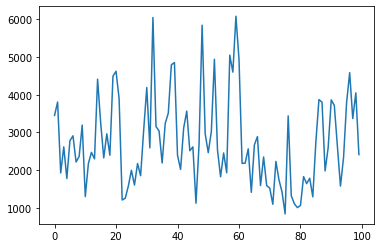

In [19]:
#bonne loss bien merdique
plt.plot(losses)